In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

### **Phrase and Dictionary Construction**

In [2]:
df = pd.read_csv("../data/cleaned.csv",usecols=['review'])
df.head()

,review
0,As usual the flight is delayed. BA try to blam...
1,I had the most fantastic BA Flight today. The ...
2,Couldn’t book in online. Arrived at check in t...
3,London Heathrow to Mumbai in a Boeing 787-8 in...
4,"Keflavík, Iceland to London Heathrow on an A32..."


In [3]:
texts = df.copy()

In [4]:
texts.describe()

,review
count,3604
unique,3604
top,As usual the flight is delayed. BA try to blam...
freq,1


In [5]:
texts.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3604 entries, 0 to 3603
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  3604 non-null   object
dtypes: object(1)
memory usage: 3.7 MB


In [6]:
from spacy.lang.en.stop_words import STOP_WORDS
all_stopwords = STOP_WORDS
# Run this only once

# Before removing some stopwords
print(all_stopwords,"\n")

# Removing some stopwords
all_stopwords -= {
   "nor","cannot","serious","over",'or',"seemed",
   "not","no","neither","otherwise","except"
}

# After removing some stopwords
my_stop_words = set(all_stopwords) # My own stop words
print(my_stop_words)

{"'ll", 'onto', 'up', 'me', 'another', 'here', 'us', 'seemed', '‘m', 'am', 'part', 'none', '‘ll', 'thereupon', 'to', 'herself', 'can', 'further', 're', 'very', 'cannot', 'whither', 'get', 'such', 'twenty', 'after', 'seeming', 'perhaps', 'beside', 'nevertheless', 'my', 'because', 'whereas', 'besides', 'third', 'becomes', 'nine', 'last', 'except', 'themselves', 'how', 'ever', 'beforehand', 'first', 'ourselves', 'down', 'become', 'should', 'would', 'no', 'namely', 'then', 'fifteen', 'front', 'everywhere', 'whom', 'nowhere', 'eleven', 'put', 'alone', 'seem', 'its', 'itself', 'had', 'least', 'n‘t', 'since', 'anyhow', 'however', 'behind', 'sometime', '’re', 'towards', 'were', 'are', 'made', 'that', 'now', 'myself', 'otherwise', 'is', 'your', 'upon', 'everyone', 'move', 'but', 'most', 'than', 'serious', 'herein', 'various', 'forty', 'indeed', 'neither', 'you', 'using', 'him', 'nor', 'she', 'what', 'anywhere', 'whereby', 'does', 'whether', 'only', 'once', 'above', 'his', 'do', 'fifty', 'name',

In [7]:
def preprocess(sent):
    '''Cleans text data up, leaving only 2 or
        more char long non-stopwords composed of A-Z & a-z only
        in lowercase'''
    # lowercase
    sentence = sent.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ",sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Removing digits
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # Removing puntuactions
    # sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  
    # When we remove apostrophe from the word "Mark's", 
    # the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Next, we remove all the single characters and replace it by a space 
    # which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.

    return sentence

In [8]:
texts['cleaned_reviews'] = texts['review'].apply(preprocess)

In [9]:
nlp = spacy.load('en_core_web_sm')

def spcay_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

texts['tokens'] = texts['cleaned_reviews'].apply(spcay_tokeniser)

In [10]:
texts.head()

,review,cleaned_reviews,tokens
0,As usual the flight is delayed. BA try to blam...,as usual the flight is delayed ba try to blame...,"[usual, flight, delay, ba, try, blame, inabili..."
1,I had the most fantastic BA Flight today. The ...,i had the most fantastic ba flight today the c...,"[fantastic, ba, flight, today, cabin, crew, se..."
2,Couldn’t book in online. Arrived at check in t...,couldn book in online arrived at check in to f...,"[couldn, book, online, arrive, check, find, bu..."
3,London Heathrow to Mumbai in a Boeing 787-8 in...,london heathrow to mumbai in boeing in busines...,"[london, heathrow, mumbai, boeing, business, c..."
4,"Keflavík, Iceland to London Heathrow on an A32...",keflav iceland to london heathrow on an in bus...,"[keflav, iceland, london, heathrow, business, ..."


In [11]:
def inspector(index_value=0):
    print(texts['review'][index_value],"\n")
    print(texts['cleaned_reviews'][index_value],"\n")
    print(texts['tokens'][index_value])
inspector(10)

A simple story with an unfortunate outcome that really could happen to anyone. My partner and I recently started working after studying purchased two tickets to travel from London City Airport to Frankfurt. When we purchased the tickets, I mistakenly entered my name twice (e.g. Mr John Smith and Ms John Smith). Little did we know that our 1 simple mistake would cost us over 300 pounds. Upon arriving at the airport we were told there was no way to change the name (apparently they can only change 3 letters where there has been a typo?) and I had no other option to purchase the last remaining ticket if I wanted to board the flight - the price: almost seven times (!) higher than my original ticket. Zero empathy was shown. Zero alternative was offered. Trusting BA's staff and under the pretence that there was apparently no other way we could board the flight we bought this ticket. Immediately after I purchased the ticket I contacted BA's 'Commercial Change Booking Team' and informed them of

In [12]:
# Compute bigrams
from gensim.models import Phrases,EnsembleLda
from gensim.models.phrases import Phraser,ENGLISH_CONNECTOR_WORDS

In [13]:
docs = texts['tokens'].tolist()

In [14]:
def inspector_two(index_value=0):
    print(docs[index_value])
inspector_two(10)

['simple', 'story', 'unfortunate', 'outcome', 'happen', 'partner', 'recently', 'start', 'work', 'study', 'purchase', 'ticket', 'travel', 'london', 'city', 'airport', 'frankfurt', 'purchase', 'ticket', 'mistakenly', 'enter', 'twice', 'mr', 'john', 'smith', 'ms', 'john', 'smith', 'little', 'know', 'simple', 'mistake', 'cost', 'over', 'pound', 'arrive', 'airport', 'tell', 'no', 'way', 'change', 'apparently', 'change', 'letter', 'typo', 'no', 'option', 'purchase', 'remain', 'ticket', 'want', 'board', 'flight', 'price', 'seven', 'time', 'high', 'original', 'ticket', 'zero', 'empathy', 'show', 'zero', 'alternative', 'offer', 'trust', 'ba', 'staff', 'pretence', 'apparently', 'no', 'way', 'board', 'flight', 'buy', 'ticket', 'immediately', 'purchase', 'ticket', 'contact', 'ba', 'commercial', 'change', 'book', 'team', 'inform', 'situation', 'service', 'representative', 'apologise', 'tell', 'change', 'cost', 'small', 'fee', 'offer', 'cancel', 'original', 'ticket', 'issue', 'partial', 'refund', 'a

In [15]:
# Add bigrams to docs (only ones that appear 20 times or more)
bigram_phrases = Phrases(docs, min_count=20,connector_words=ENGLISH_CONNECTOR_WORDS)
bigram = Phraser(bigram_phrases)

In [16]:
def make_bigram(texts):
    return([bigram[doc] for doc in texts])

bigram_docs = make_bigram(docs)

In [17]:
def phrase_inspector(index_value=0):
    print(bigram_docs[index_value])
inspector(50)
print()
phrase_inspector(50)

I booked our first out of country trip to take my husband on a surprise trip to Monaco. I gave us over 3 hours for our connecting flight to and from home through Heathrow. Our flight left Seattle an hour late causing us to miss our connecting flight. We were rescheduled before we even landed. They booked us on a flight 7 hours later and offered no food tickets or any other type of reimbursement. Additionally we sat in their customer service line for an hour and a half to see if they could rebook us on an earlier flight, to watch them continually assist other customers that walked up outside of the queue (no earlier flights were available). When we arrived in Nice, France the airport was closed, including the rental car desk. We were not offered any assistance from the airline on a room or other accommodation for the night. We found a cab, which cost us 85 euros one one to get to our hotel. We thought there is no way something like this could happen on the way home….we were wrong. Our f

In [18]:
# Remove rare adn common tokens
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents
id2word = Dictionary(bigram_docs)
# or 
# dictionary = Dictionary(docs)

# Filter out words that occur in less than 20 documents, or 
# more than 50% of the documents
# https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
id2word.filter_extremes(no_below=20,no_above=0.6)

In [19]:
id2word.most_common(15) # most common words

[('seat', 4111),
 ('no', 2770),
 ('service', 2468),
 ('fly', 2382),
 ('good', 2374),
 ('time', 2372),
 ('food', 2078),
 ('british_airways', 1606),
 ('hour', 1578),
 ('or', 1532),
 ('airline', 1478),
 ('check', 1463),
 ('staff', 1423),
 ('london', 1354),
 ('passenger', 1271)]

In [20]:
# Bag-of-words representation of the documents.
# Term document frequency 
bow_corpus = [id2word.doc2bow(doc) for doc in bigram_docs]

# Create corpus
text_corpus = bigram_docs

In [21]:
print(f"Number of unique tokens: {len(id2word)}")
print(f"Number of documents: {len(bow_corpus)}")

Number of unique tokens: 1594
Number of documents: 3604


In [22]:
# Verifyting BOW is set correctly
def bow_verifier(index_value=0):
    print("Original text and tokens")
    inspector(index_value)
    print("\nPhrases")
    phrase_inspector(index_value)
    print()
    print(f"BoW representation: {bow_corpus[index_value]}")

    doc = f"document_{index_value}"
    doc = bow_corpus[index_value]
    for i in range(len(doc)):
        print(f"Word {doc[i][0]}, {id2word[doc[i][0]]}, appears {doc[i][1]}")

bow_verifier(10)

Original text and tokens
A simple story with an unfortunate outcome that really could happen to anyone. My partner and I recently started working after studying purchased two tickets to travel from London City Airport to Frankfurt. When we purchased the tickets, I mistakenly entered my name twice (e.g. Mr John Smith and Ms John Smith). Little did we know that our 1 simple mistake would cost us over 300 pounds. Upon arriving at the airport we were told there was no way to change the name (apparently they can only change 3 letters where there has been a typo?) and I had no other option to purchase the last remaining ticket if I wanted to board the flight - the price: almost seven times (!) higher than my original ticket. Zero empathy was shown. Zero alternative was offered. Trusting BA's staff and under the pretence that there was apparently no other way we could board the flight we bought this ticket. Immediately after I purchased the ticket I contacted BA's 'Commercial Change Booking T

### **Determining best number of topics**

In [23]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

[Link](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html)

**chunksize** controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

**passes** controls how often we train the model on the entire corpus. Another word for passes might be “epochs”. 

**iterations** is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

In [24]:
def compute_coherence_scores(corpus,dictionary,num_topics,num_models):
    lda_model = EnsembleLda(
                            corpus=corpus,
                            num_models=num_models,
                            random_state=42,
                            distance_workers =2,
                            # Lda kwargs
                            num_topics=num_topics,
                            chunksize=100,
                            passes=300,
                            iterations=500,
                            eval_every=None
                            # Don't evaluate model perplexity, takes too much time.
                            )

    coherence_model_lda = CoherenceModel(
                                        model=lda_model,
                                        dictionary=dictionary,
                                        corpus=corpus,
                                        coherence='u_mass',
                                        processes=-2
                                        # texts = text_corpus           
                                        )

    return coherence_model_lda.get_coherence()                    

In [25]:
# score = compute_coherence_scores(
#                                 corpus=bow_corpus,dictionary=id2word,
#                                 num_models=3,num_topics=4
#                             )
# print(score) #-1.4286749104013903

-1.4286749104013903


In [27]:
model_results = {
    'topics':[],
    'coherence_score':[]
}

start = 2
stop = 11

In [28]:
for k in range(start,stop):
    score = compute_coherence_scores(
                                    corpus=bow_corpus,dictionary=id2word,
                                    num_models=3,num_topics=k
                                )
    model_results['topics'].append(k)
    model_results['coherence_score'].append(score)

In [29]:
font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 16,
        }

In [32]:
model_results_frame = pd.DataFrame(model_results)
model_results_frame.to_csv("model_versions/results/bigrams_ensembles_results_umass.csv", index=False)

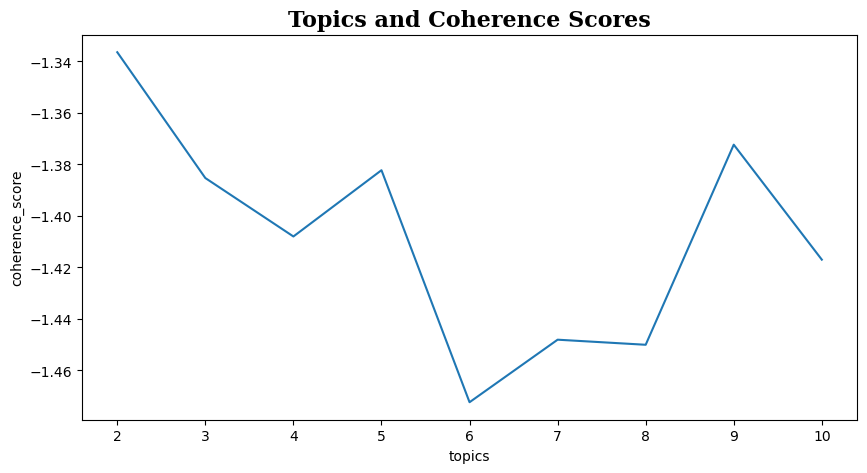

In [33]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=model_results_frame,x = "topics",y='coherence_score')
plt.title("Topics and Coherence Scores",fontdict=font_title)
plt.show()

In [34]:
zipped_values = zip(*model_results.values())
print(list(zipped_values))

[(2, -1.3363984706544614), (3, -1.385269204715315), (4, -1.407967144152936), (5, -1.3822267601748832), (6, -1.4723489546516535), (7, -1.448061044977602), (8, -1.4500330373561852), (9, -1.3723091683371365), (10, -1.4169731401237806)]


In [35]:
coherence_scores = []
for topic, coherence_score in zip(*model_results.values()):
    print(f"Topic: {topic} has a coherence score of: {coherence_score}")
    coherence_scores.append(coherence_score)

Topic: 2 has a coherence score of: -1.3363984706544614
Topic: 3 has a coherence score of: -1.385269204715315
Topic: 4 has a coherence score of: -1.407967144152936
Topic: 5 has a coherence score of: -1.3822267601748832
Topic: 6 has a coherence score of: -1.4723489546516535
Topic: 7 has a coherence score of: -1.448061044977602
Topic: 8 has a coherence score of: -1.4500330373561852
Topic: 9 has a coherence score of: -1.3723091683371365
Topic: 10 has a coherence score of: -1.4169731401237806


In [36]:
print(sorted(coherence_scores))
print(coherence_scores[np.argmin(coherence_scores,axis=0)])

[-1.4723489546516535, -1.4500330373561852, -1.448061044977602, -1.4169731401237806, -1.407967144152936, -1.385269204715315, -1.3822267601748832, -1.3723091683371365, -1.3363984706544614]
-1.4723489546516535


Use of ensemebles suggests the use of 6 topics with bigrams.

*Kindly note that pyLDAvis topics numbering starts from 1, so topic 1 is 0, etc*

In [37]:
lda_model_six = EnsembleLda(
                    corpus=bow_corpus,
                    num_models=3,
                    random_state=42,
                    distance_workers =2,
                    # Lda kwargs
                    num_topics=6,
                    chunksize=100,
                    passes=300,
                    iterations=500,
                    eval_every=None
                    # Don't evaluate model perplexity, takes too much time.
                    )

In [41]:
lda_model_six.print_topics(num_words=50)

[(0,
  '0.025*"81" + 0.025*"67" + 0.023*"110" + 0.020*"31" + 0.019*"87" + 0.017*"95" + 0.015*"122" + 0.015*"16" + 0.012*"75" + 0.012*"160" + 0.011*"1" + 0.010*"123" + 0.010*"700" + 0.010*"106" + 0.010*"398" + 0.010*"73" + 0.009*"738" + 0.009*"88" + 0.009*"45" + 0.009*"29" + 0.009*"108" + 0.008*"856" + 0.008*"102" + 0.008*"282" + 0.008*"94" + 0.008*"9" + 0.008*"30" + 0.008*"444" + 0.007*"6" + 0.007*"11" + 0.007*"154" + 0.007*"316" + 0.007*"127" + 0.007*"288" + 0.007*"866" + 0.006*"269" + 0.006*"352" + 0.006*"44" + 0.006*"509" + 0.006*"147" + 0.006*"717" + 0.005*"84" + 0.005*"79" + 0.005*"32" + 0.005*"612" + 0.005*"634" + 0.005*"650" + 0.005*"38" + 0.005*"161" + 0.005*"404"'),
 (1,
  '0.025*"42" + 0.022*"398" + 0.022*"650" + 0.021*"88" + 0.017*"122" + 0.017*"217" + 0.016*"143" + 0.015*"10" + 0.014*"29" + 0.014*"470" + 0.012*"16" + 0.011*"20" + 0.010*"158" + 0.010*"424" + 0.009*"410" + 0.008*"67" + 0.008*"950" + 0.008*"34" + 0.007*"11" + 0.007*"449" + 0.007*"43" + 0.007*"1215" + 0.006*"31

### **Visualising the topics**

In [39]:
pyLDAvis.enable_notebook()
vis_data_six = gensimvis.prepare(
    lda_model_six,bow_corpus,
    id2word,sort_topics=False
)
pyLDAvis.save_html(vis_data_six,'topic_visuals_bigrams/ensembles/six_topics.html')
pyLDAvis.display(vis_data_six)

AttributeError: 'EnsembleLda' object has no attribute 'num_topics'

Raise an issue on GitHub concerning this functionality 